`/interactive-runner`

In [1]:
!rm -rf /kaggle/working/data
!rm /kaggle/working/data.zip
!rm results.csv
!rm -rf /kaggle/working/artefacts

rm: cannot remove '/kaggle/working/data.zip': No such file or directory
rm: cannot remove 'results.csv': No such file or directory


In [2]:
!pip install gdown
#import gdown
#from cld_data_processing import download_data

`/model/util.py`

In [7]:
import keras
import numpy as np
import pandas as pd
import tensorflow as tf

from dataclasses import dataclass
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from tensorflow.data import Dataset
from tensorflow.keras import layers, callbacks
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Dropout, Flatten, GlobalAveragePooling2D
from typing import NamedTuple, Tuple


class Params(NamedTuple):
    """
    Job Parameters Struct
    """
    image_size: int
    batch_size: int
    epochs: int
    epsilon: float
    early_stopping: bool
    early_stopping_patience: int
    adjust_learning_rate: bool


@dataclass
class ModelWrapper():
    """
    Util class to hold the "outer" model, and the inner base model
    so that training can be fine-tuned.
    """
    
    model: keras.Model
    base_model: keras.Model

        
def create_convnext_base(params: Params) -> ModelWrapper:
    return create_model(tf.keras.applications.ConvNeXtBase, "baseline", DEFAULT_PARAMS)


def create_model(base_model_fn: str, name: str, params: Params) -> ModelWrapper:
    """
    Create Keras application model, e.g.
        tf.keras.applications.EfficientNetV2B0
        tf.keras.applications.ConvNeXtBase
    with a custom top.
    """
    # i = 0
    # name=f"{name}-{(i:=i+1)}"
    # name = [name+str(i) for i in range(17)]
    inputs = keras.Input(shape=(params.image_size, params.image_size, 3))
    # Base
    base_model = base_model_fn(weights='imagenet', include_top=False)
    base_model.trainable = False
    # set training=F here per https://keras.io/guides/transfer_learning/
    x = base_model(inputs, training=False)
    # Head
    x = GlobalAveragePooling2D()(x)
    x = Flatten()(x)
    x = Dense(1024, activation="relu")(x)
    x = Dropout(0.5)(x)
    x = Dense(1024, activation="relu")(x)
    x = Dropout(0.5)(x)
    outputs = Dense(5, activation="softmax")(x)
    model = keras.Model(inputs, outputs)

    return ModelWrapper(model, base_model)


def run_task(task_id: str, model_wrapper: ModelWrapper,
             ds_train: Dataset, ds_valid: Dataset, ds_test: Dataset,
             params: Params, weights = None) -> Tuple[pd.DataFrame, pd.DataFrame]:
    
    model = model_wrapper.model
    # train
    df_train = train(task_id, model, ds_train, ds_valid, params)
    # test
    test_result = model.evaluate(ds_test)
    df_test = create_test_record(task_id, test_result)
    # save CM too
    save_confusion_matrix(ds_test, model, task_id)
    return df_train, df_test


def train(task_id: str, model: Model,
             ds_train_: Dataset, ds_valid_: Dataset,
             params: Params, weights = None) -> pd.DataFrame:
    
    model.compile(
        optimizer=tf.keras.optimizers.Adam(epsilon=params.epsilon),
        loss="categorical_crossentropy",
        metrics=['accuracy']
    )

    early_stopping = callbacks.EarlyStopping(
        min_delta=0.0001,
        patience=params.early_stopping_patience,
        restore_best_weights=True,
        verbose = 1
    )
    
    reduce_lr = callbacks.ReduceLROnPlateau(
        monitor = 'val_loss', factor = 0.3, 
        patience = 3, min_delta = 0.001, 
        mode = 'min', verbose = 1)
    
    cbs = []
    if params.early_stopping:
        print("Using EarlyStopping")
        cbs += [early_stopping]
    if params.adjust_learning_rate:
        print("Using ReduceLROnPlateau")
        cbs += [reduce_lr]

    history = model.fit(
        ds_train_,
        validation_data=ds_valid_,
        epochs=params.epochs,
        verbose=1,
        callbacks=cbs,
        class_weight=weights
    )
   
    df_hist = pd.DataFrame(history.history)
    # df_hist = df_hist.reset_index()
    df_hist["task_id"] = task_id
    df_hist["epoch"] = df_hist.index
   
    return df_hist


def create_test_record(task_id: str, result: list[float]):
    return pd.DataFrame({"task_id": [task_id], "test_loss" : [result[0]], "test_accuracy": [result[1]]})


def save_confusion_matrix(ds: Dataset, model: Model, task_id: str) -> None:
    path = f"artefacts/conf_mat_{task_id}.png"
    probabilities = model.predict(ds)
    predictions = np.argmax(probabilities, axis=1)

    one_hot_labels = np.concatenate([y for x, y in ds], axis=0)
    labels = [np.argmax(x) for x in one_hot_labels]
    
    result = confusion_matrix(labels, predictions, labels=[0,1,2,3,4], normalize='pred')
    disp = ConfusionMatrixDisplay(result, display_labels=[0,1,2,3,4])
    disp.plot()
    disp.ax_.set_title(task_id)
    
    print(f"Saving confusion matrix to {path}")
    disp.figure_.savefig(f"artefacts/conf_mat_{task_id}.png", dpi=300)

2024-03-29 20:37:14.726036: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-03-29 20:37:14.726157: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-03-29 20:37:14.883062: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


`/data/data_processing.py`

In [8]:
import gdown
import keras
import pandas as pd
import random
import shutil
import tensorflow as tf
import os
import zipfile

# handle different dir structure kaggle vs colab
try:
    from AMLS_II_assignment23_24.model.util import Params
except ModuleNotFoundError:
    pass

from pathlib import Path
from sklearn.model_selection import train_test_split
from sklearn.utils.class_weight import compute_class_weight
from tensorflow.data import Dataset
from tensorflow.data.experimental import AUTOTUNE
from tensorflow.keras import layers, callbacks
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing import image_dataset_from_directory
from typing import Tuple


def data_preprocessing(path: Path,
                       params: Params,
                       force=False) -> Tuple[Dataset, Dataset, Dataset, dict]:
    """
    """
    file = download_data(path, force)
    
    data_path = path / "data"
    if force:
        shutil.rmtree(data_path)
        
    if not data_path.exists():
        data_path.mkdir(parents=True, exist_ok=True)
       
        with zipfile.ZipFile(file, "r") as z:
            z.extractall(data_path)
        
    df_images = pd.read_csv((data_path / "train.csv"))
    
#     imgs1 = random.sample(df_images[df_images.label==3].image_id.tolist(), k=6579)
#     imgs2 = df_images[df_images.label!=3].image_id.tolist()
    
#     df_images = df_images[df_images.image_id.isin((imgs1+imgs2))].copy()
    
    X_train, X_test, y_train, y_test = train_test_split(df_images.image_id, df_images.label, test_size=0.2, random_state=12)
    
    X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, test_size=0.25, random_state=12)
    
    train_path = create_ds_tree(X_train, y_train, data_path, "train")
    valid_path = create_ds_tree(X_valid, y_valid, data_path, "valid")
    test_path = create_ds_tree(X_test, y_test, data_path, "test")
    
    ds_train = create_dataset(train_path, params.image_size, params.batch_size)
    ds_valid = create_dataset(valid_path, params.image_size, params.batch_size)
    ds_test = create_dataset(test_path, params.image_size, params.batch_size, False)

    return ds_train, ds_valid, ds_test, extract_class_weights(df_images)


def download_data(path: Path, force=False) -> Path:
    """
    """
    url = "https://drive.google.com/uc?id=1TJBf1HZxAMpowZ92BcgS5N_NPHE7LPOT"
    output = path / "data.zip"
    if not Path(output).exists() or force:
        gdown.download(url, str(output), quiet=False)
    return output


def create_ds_tree(x, y, path: Path, name: str) -> Path:
    """
    Creates the directory structure for the given dataset.
    """
    ds_path = path / name
    if not ds_path.exists():
        ds_path.mkdir(parents=True, exist_ok=True)

        for lab in y.unique():
            (ds_path / str(lab)).mkdir(exist_ok=True)

        source_path = path / "train_images"
        
        for img, lab in zip(x, y):
            src = source_path / img
            dest = ds_path / str(lab) / img
            shutil.move(src, dest)
        
    return ds_path


def create_dataset(path: Path, img_size: int, batch_size: int, shuffle = True) -> Dataset:
    """
    """
    return image_dataset_from_directory(
        path,
        labels='inferred',
        label_mode='categorical',
        image_size=[img_size, img_size],
        batch_size=batch_size,
        seed=12345,
        shuffle=shuffle
    )


def extract_class_weights(df_data: pd.DataFrame) -> dict:
    classes = df_data.label.unique()
    class_weights = compute_class_weight(class_weight='balanced',
                                         classes=classes,
                                         y=df_data.label)

    return dict(zip(classes, class_weights))


def augment_dataset(ds: Dataset, num_repeats: int) -> Dataset:
    """
    """
    def augment(image, label):
        seed = 12345
        image = tf.image.random_flip_left_right(image, seed)
        image = tf.image.random_flip_up_down(image, seed)
        image = tf.image.random_brightness(image, 0.2, seed)
        return image, label

    return (
        ds
        .repeat(num_repeats)
        .map(augment)
        .cache()
        .prefetch(buffer_size=AUTOTUNE)
    )

In [9]:
class ResultCollector():
    
    def __init__(
        self,
        path: Path
    ):
        self.path = path
        self.train_details = pd.DataFrame
        self.test_scores = pd.DataFrame

    def add_task_results(self, df_train, df_test) -> None:
        self.add_train_details(df_train)
        self.add_test_scores(df_test)
        
    def add_train_details(self, df: pd.DataFrame) -> None:
        if self.train_details.empty:
            self.train_details = df
        else:
            self.train_details = pd.concat([self.train_details, df])
        
        self._save(self.train_details, "train_details.csv")
        

    def get_train_details(self) -> pd.DataFrame:
        return self.train_details
    
    def add_test_scores(self, df: pd.DataFrame) -> None:
        if self.test_scores.empty:
            self.test_scores = df
        else:
            self.test_scores = pd.concat([self.test_scores, df])
            
        self._save(self.test_scores, "test_scores.csv")
            
    def get_test_scores(self) -> pd.DataFrame:
        return self.test_scores
    
    def _save(self, df: pd.DataFrame, name: str) -> None:
        df.to_csv(self.path / name, index=False)

`main.py`

In [10]:
import datetime
import os
import pandas as pd
import tensorflow as tf

# handle different dir structure kaggle vs colab
try:
    from AMLS_II_assignment23_24.data_processing import pre_processing as data
    from AMLS_II_assignment23_24.model import util as model_util
    from AMLS_II_assignment23_24.model.util import Params, ResultCollector
except ModuleNotFoundError:
    pass

from docopt import docopt
from pathlib import Path

tf.random.set_seed(67890)

DEFAULT_PARAMS = Params(255, 196, 50, 0.005, True, 5, False)
## DEFAULT_PARAMS = model_util.Params(50, 196, 1, True, 5, False)
#DEFAULT_PARAMS = Params(50, 196, 1, 0.005, True, 5, False)
print(DEFAULT_PARAMS)

ARTEFACTS_PATH = Path("artefacts")
ARTEFACTS_PATH.mkdir(parents=True, exist_ok=True)

collector = ResultCollector(ARTEFACTS_PATH)

# Process Data
print("==== Loading Data ====")
cwd = os.getcwd()
# ds_train, ds_valid, ds_test, class_weights = data_preprocessing(Path(cwd), DEFAULT_PARAMS)
# print(f"Class Weights: {class_weights}")

# print("==== Task A: Baseline Model ====")

# model = create_convnext_base(DEFAULT_PARAMS)
# df_train, df_test = run_task("A_base", model, ds_train, ds_valid, ds_test, DEFAULT_PARAMS)
# collector.add_task_results(df_train, df_test)

# print("==== Task B: Baseline + Data Augmentation ====")
# {
#     """
#     Per task A, but with data augmentation.
#     """
#     ds_train_aug = augment_dataset(ds_train, 2)
#     model = create_convnext_base(DEFAULT_PARAMS)
#     df_train, df_test = run_task("B_base_aug", model, ds_train_aug, ds_valid, ds_test, DEFAULT_PARAMS)
#     collector.add_task_results(df_train, df_test)    
# }

# print("==== Task C: Baseline + Data Augmentation + Class Weights ====")
# model = create_convnext_base(DEFAULT_PARAMS)
# {
#     """
#     Per task B but, given the large class imbalance, class weight supplied.
#     """
#     ds_train_aug = augment_dataset(ds_train, 2)
#     df_train, df_test = run_task("C_base_aug_wgts", model, ds_train_aug, ds_valid, ds_test, DEFAULT_PARAMS, class_weights)
#     collector.add_task_results(df_train, df_test)    
# }

# print("==== Task D: Baseline + Data Augmentation + Class Weights + Fine Tune ====")
# {
#     """
#     Per task C but, given the large class imbalance, class weight supplied.
#     """
#     fine_tune_params = Params(50, 196, 1, 1e-5, True, 5, False)
#     print(fine_tune_params)
#     model.base_model.trainable = True
#     ds_train_aug = augment_dataset(ds_train, 2)
#     df_train, df_test = run_task("D_base_aug_wgts_ft", model, ds_train_aug, ds_valid, ds_test, DEFAULT_PARAMS, class_weights)
#     collector.add_task_results(df_train, df_test)    
# }


Params(image_size=255, batch_size=196, epochs=50, epsilon=0.005, early_stopping=True, early_stopping_patience=5, adjust_learning_rate=False)
==== Loading Data ====


In [ ]:
model.model.save("/kaggle/working/artefacts/model_a.keras")

Batch Size: 64
Start: 2024-03-29 16:53:41.291004
Params(image_size=255, batch_size=64, epochs=50, epsilon=0.005, early_stopping=True, early_stopping_patience=5, adjust_learning_rate=False)
Found 12837 files belonging to 5 classes.
Found 4280 files belonging to 5 classes.
Found 4280 files belonging to 5 classes.
Using EarlyStopping
Epoch 1/50
  1/201 ━━━━━━━━━━━━━━━━━━━━ 54:31 16s/step - accuracy: 0.1562 - loss: 1.8721

W0000 00:00:1711731240.154413     127 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1711731240.154843     127 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1711731240.155301     127 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1711731240.156283     127 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1711731240.156658     127 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1711731240.157027     127 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1711731240.157398     127 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1711731240.157755     127 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


201/201 ━━━━━━━━━━━━━━━━━━━━ 0s 206ms/step - accuracy: 0.6062 - loss: 1.1075

W0000 00:00:1711731281.371245     127 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1711731281.371648     127 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1711731281.372095     127 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1711731281.373037     127 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1711731281.373400     127 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1711731281.373723     127 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1711731281.374043     127 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1711731281.374376     127 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


201/201 ━━━━━━━━━━━━━━━━━━━━ 76s 296ms/step - accuracy: 0.6065 - loss: 1.1068 - val_accuracy: 0.7194 - val_loss: 0.7501
Epoch 2/50
201/201 ━━━━━━━━━━━━━━━━━━━━ 49s 240ms/step - accuracy: 0.6972 - loss: 0.8144 - val_accuracy: 0.7369 - val_loss: 0.7037
Epoch 3/50
201/201 ━━━━━━━━━━━━━━━━━━━━ 82s 241ms/step - accuracy: 0.7191 - loss: 0.7547 - val_accuracy: 0.7502 - val_loss: 0.6791
Epoch 4/50
201/201 ━━━━━━━━━━━━━━━━━━━━ 49s 238ms/step - accuracy: 0.7312 - loss: 0.7239 - val_accuracy: 0.7544 - val_loss: 0.6747
Epoch 5/50
201/201 ━━━━━━━━━━━━━━━━━━━━ 49s 240ms/step - accuracy: 0.7417 - loss: 0.6894 - val_accuracy: 0.7577 - val_loss: 0.6509
Epoch 6/50
201/201 ━━━━━━━━━━━━━━━━━━━━ 49s 239ms/step - accuracy: 0.7500 - loss: 0.6780 - val_accuracy: 0.7626 - val_loss: 0.6442
Epoch 7/50
201/201 ━━━━━━━━━━━━━━━━━━━━ 49s 239ms/step - accuracy: 0.7593 - loss: 0.6457 - val_accuracy: 0.7579 - val_loss: 0.6468
Epoch 8/50
201/201 ━━━━━━━━━━━━━━━━━━━━ 82s 239ms/step - accuracy: 0.7641 - loss: 0.6381 - val

W0000 00:00:1711732213.082649     129 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1711732213.083250     129 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1711732213.083638     129 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1711732213.084813     129 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1711732213.085241     129 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1711732213.085627     129 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1711732213.086029     129 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1711732213.086695     129 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


67/67 ━━━━━━━━━━━━━━━━━━━━ 17s 203ms/step


W0000 00:00:1711732226.497978     126 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1711732226.498314     126 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1711732226.498765     126 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1711732226.501754     126 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1711732226.502110     126 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1711732226.502486     126 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


Saving confusion matrix to artefacts/conf_mat_A_bs_64.png
67/67 ━━━━━━━━━━━━━━━━━━━━ 12s 176ms/step - accuracy: 0.6777 - loss: 0.8326
[0.5994129180908203, 0.7782710194587708]
End: 2024-03-29 17:10:53.691764
Batch Size: 128
Start: 2024-03-29 17:10:53.691798
Params(image_size=255, batch_size=128, epochs=50, epsilon=0.005, early_stopping=True, early_stopping_patience=5, adjust_learning_rate=False)
Found 12837 files belonging to 5 classes.
Found 4280 files belonging to 5 classes.
Found 4280 files belonging to 5 classes.
Using EarlyStopping
Epoch 1/50


W0000 00:00:1711732278.615678     129 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1711732278.615994     129 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1711732278.616467     129 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1711732278.616842     129 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1711732278.617181     129 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1711732278.617512     129 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1711732278.617826     129 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1711732278.618171     129 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


101/101 ━━━━━━━━━━━━━━━━━━━━ 0s 397ms/step - accuracy: 0.5834 - loss: 1.1934

W0000 00:00:1711732318.503154     126 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1711732318.503540     126 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1711732318.503904     126 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1711732318.504851     126 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1711732318.505233     126 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1711732318.505602     126 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1711732318.505948     126 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1711732318.506320     126 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


101/101 ━━━━━━━━━━━━━━━━━━━━ 82s 589ms/step - accuracy: 0.5838 - loss: 1.1920 - val_accuracy: 0.6984 - val_loss: 0.7937
Epoch 2/50
101/101 ━━━━━━━━━━━━━━━━━━━━ 50s 473ms/step - accuracy: 0.6794 - loss: 0.8663 - val_accuracy: 0.7229 - val_loss: 0.7343
Epoch 3/50
101/101 ━━━━━━━━━━━━━━━━━━━━ 49s 472ms/step - accuracy: 0.7021 - loss: 0.7982 - val_accuracy: 0.7325 - val_loss: 0.7164
Epoch 4/50
101/101 ━━━━━━━━━━━━━━━━━━━━ 82s 474ms/step - accuracy: 0.7171 - loss: 0.7630 - val_accuracy: 0.7430 - val_loss: 0.6962
Epoch 5/50
101/101 ━━━━━━━━━━━━━━━━━━━━ 49s 475ms/step - accuracy: 0.7304 - loss: 0.7318 - val_accuracy: 0.7456 - val_loss: 0.6792
Epoch 6/50
101/101 ━━━━━━━━━━━━━━━━━━━━ 49s 473ms/step - accuracy: 0.7274 - loss: 0.7244 - val_accuracy: 0.7563 - val_loss: 0.6650
Epoch 7/50
101/101 ━━━━━━━━━━━━━━━━━━━━ 82s 472ms/step - accuracy: 0.7430 - loss: 0.6869 - val_accuracy: 0.7558 - val_loss: 0.6509
Epoch 8/50
101/101 ━━━━━━━━━━━━━━━━━━━━ 49s 473ms/step - accuracy: 0.7456 - loss: 0.6796 - val

W0000 00:00:1711733683.452380     127 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1711733683.452710     127 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1711733683.453124     127 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1711733683.453535     127 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1711733683.453860     127 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1711733683.454191     127 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1711733683.454522     127 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1711733683.454838     127 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


34/34 ━━━━━━━━━━━━━━━━━━━━ 17s 400ms/step


W0000 00:00:1711733696.649533     126 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1711733696.649908     126 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1711733696.650233     126 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1711733696.653330     126 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1711733696.653672     126 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1711733696.654081     126 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


Saving confusion matrix to artefacts/conf_mat_A_bs_128.png
34/34 ━━━━━━━━━━━━━━━━━━━━ 12s 340ms/step - accuracy: 0.6644 - loss: 0.8585
[0.5908013582229614, 0.7869158983230591]
End: 2024-03-29 17:35:15.054516
Batch Size: 192
Start: 2024-03-29 17:35:15.054540
Params(image_size=255, batch_size=192, epochs=50, epsilon=0.005, early_stopping=True, early_stopping_patience=5, adjust_learning_rate=False)
Found 12837 files belonging to 5 classes.
Found 4280 files belonging to 5 classes.
Found 4280 files belonging to 5 classes.
Using EarlyStopping
Epoch 1/50
66/67 ━━━━━━━━━━━━━━━━━━━━ 0s 508ms/step - accuracy: 0.5493 - loss: 1.2763

W0000 00:00:1711733794.699386     126 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1711733794.699825     126 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1711733794.700349     126 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 718ms/step - accuracy: 0.5502 - loss: 1.2739

W0000 00:00:1711733814.602308     129 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1711733814.602727     129 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1711733814.603206     129 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1711733814.606100     129 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1711733814.606399     129 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1711733814.606809     129 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


67/67 ━━━━━━━━━━━━━━━━━━━━ 97s 1s/step - accuracy: 0.5511 - loss: 1.2715 - val_accuracy: 0.6850 - val_loss: 0.8418
Epoch 2/50
67/67 ━━━━━━━━━━━━━━━━━━━━ 51s 721ms/step - accuracy: 0.6635 - loss: 0.9159 - val_accuracy: 0.7058 - val_loss: 0.7599
Epoch 3/50
67/67 ━━━━━━━━━━━━━━━━━━━━ 50s 714ms/step - accuracy: 0.6923 - loss: 0.8338 - val_accuracy: 0.7301 - val_loss: 0.7372
Epoch 4/50
67/67 ━━━━━━━━━━━━━━━━━━━━ 50s 713ms/step - accuracy: 0.7020 - loss: 0.7904 - val_accuracy: 0.7346 - val_loss: 0.7118
Epoch 5/50
67/67 ━━━━━━━━━━━━━━━━━━━━ 50s 714ms/step - accuracy: 0.7125 - loss: 0.7701 - val_accuracy: 0.7439 - val_loss: 0.7018
Epoch 6/50
67/67 ━━━━━━━━━━━━━━━━━━━━ 50s 714ms/step - accuracy: 0.7245 - loss: 0.7396 - val_accuracy: 0.7516 - val_loss: 0.6833
Epoch 7/50
67/67 ━━━━━━━━━━━━━━━━━━━━ 50s 719ms/step - accuracy: 0.7335 - loss: 0.7153 - val_accuracy: 0.7502 - val_loss: 0.6692
Epoch 8/50
67/67 ━━━━━━━━━━━━━━━━━━━━ 50s 713ms/step - accuracy: 0.7341 - loss: 0.7203 - val_accuracy: 0.7547 -

W0000 00:00:1711735241.820450     126 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1711735241.820818     126 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1711735241.821251     126 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1711735241.824221     126 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1711735241.824552     126 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1711735241.824897     126 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


Saving confusion matrix to artefacts/conf_mat_A_bs_192.png
23/23 ━━━━━━━━━━━━━━━━━━━━ 12s 489ms/step - accuracy: 0.6802 - loss: 0.8117
[0.6071330904960632, 0.7801401615142822]
End: 2024-03-29 18:01:00.093955
Batch Size: 256
Start: 2024-03-29 18:01:00.093987
Params(image_size=255, batch_size=256, epochs=50, epsilon=0.005, early_stopping=True, early_stopping_patience=5, adjust_learning_rate=False)
Found 12837 files belonging to 5 classes.
Found 4280 files belonging to 5 classes.
Found 4280 files belonging to 5 classes.
Using EarlyStopping
Epoch 1/50
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 775ms/step - accuracy: 0.5589 - loss: 1.2615

W0000 00:00:1711735335.503937     127 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1711735335.504303     127 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1711735335.504734     127 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1711735335.505763     127 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1711735335.506164     127 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1711735335.506559     127 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1711735335.506931     127 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1711735335.507318     127 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


51/51 ━━━━━━━━━━━━━━━━━━━━ 105s 1s/step - accuracy: 0.5597 - loss: 1.2592 - val_accuracy: 0.6626 - val_loss: 0.8757
Epoch 2/50
51/51 ━━━━━━━━━━━━━━━━━━━━ 52s 953ms/step - accuracy: 0.6493 - loss: 0.9605 - val_accuracy: 0.7035 - val_loss: 0.7854
Epoch 3/50
51/51 ━━━━━━━━━━━━━━━━━━━━ 52s 962ms/step - accuracy: 0.6819 - loss: 0.8691 - val_accuracy: 0.7157 - val_loss: 0.7487
Epoch 4/50
51/51 ━━━━━━━━━━━━━━━━━━━━ 51s 948ms/step - accuracy: 0.6916 - loss: 0.8172 - val_accuracy: 0.7173 - val_loss: 0.7325
Epoch 5/50
51/51 ━━━━━━━━━━━━━━━━━━━━ 51s 952ms/step - accuracy: 0.7035 - loss: 0.7914 - val_accuracy: 0.7357 - val_loss: 0.7098
Epoch 6/50
51/51 ━━━━━━━━━━━━━━━━━━━━ 51s 950ms/step - accuracy: 0.7082 - loss: 0.7719 - val_accuracy: 0.7421 - val_loss: 0.6989
Epoch 7/50
51/51 ━━━━━━━━━━━━━━━━━━━━ 51s 948ms/step - accuracy: 0.7217 - loss: 0.7500 - val_accuracy: 0.7453 - val_loss: 0.6884
Epoch 8/50
51/51 ━━━━━━━━━━━━━━━━━━━━ 52s 954ms/step - accuracy: 0.7256 - loss: 0.7359 - val_accuracy: 0.7491 

W0000 00:00:1711737282.122741     129 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


Saving confusion matrix to artefacts/conf_mat_A_bs_256.png
17/17 ━━━━━━━━━━━━━━━━━━━━ 12s 660ms/step - accuracy: 0.6971 - loss: 0.8022
[0.5909342765808105, 0.7890186905860901]
End: 2024-03-29 18:35:01.277658


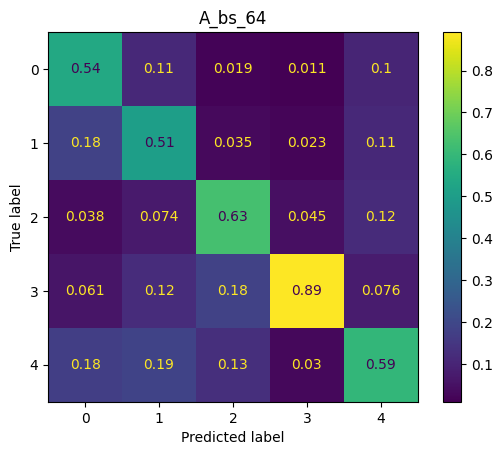

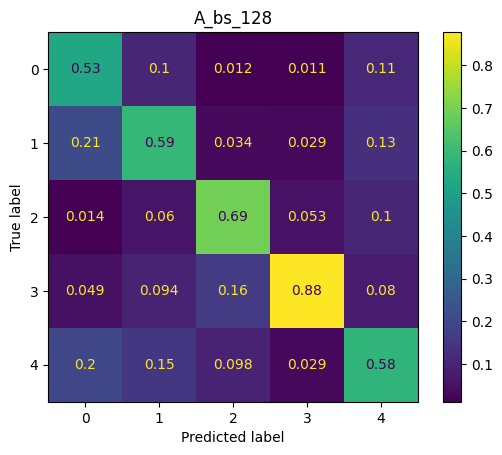

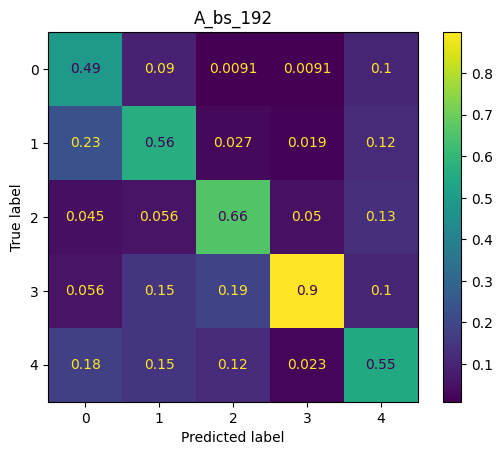

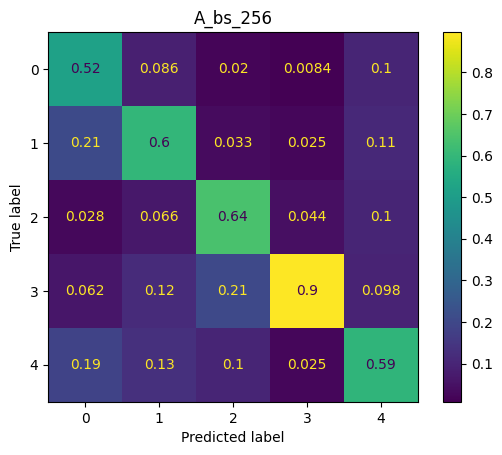

In [10]:
for bs in [64, 128, 192, 256]:
    print(f"Batch Size: {bs}")
    print(f"Start: {datetime.datetime.now()}")
    batch_size_params = Params(255, bs, 50, 0.005, True, 5, False)
    print(batch_size_params)
    ds_train, ds_valid, ds_test, class_weights = data_preprocessing(Path(cwd), batch_size_params)
    model = create_model(tf.keras.applications.ConvNeXtTiny, "base", batch_size_params)
    df_train, df_test = run_task(f"A_bs_{bs}", model, ds_train, ds_valid, ds_test, batch_size_params)
    collector.add_task_results(df_train, df_test)
    print(model.model.evaluate(ds_test))
    print(f"End: {datetime.datetime.now()}")

In [ ]:
for bs in [512, 768, 1024]:
    print(f"Batch Size: {bs}")
    print(f"Start: {datetime.datetime.now()}")
    batch_size_params = Params(255, bs, 50, 0.005, True, 5, False)
    print(batch_size_params)
    ds_train, ds_valid, ds_test, class_weights = data_preprocessing(Path(cwd), batch_size_params)
    model = create_model(tf.keras.applications.ConvNeXtTiny, "base", batch_size_params)
    df_train, df_test = run_task(f"A_bs_{bs}", model, ds_train, ds_valid, ds_test, batch_size_params)
    collector.add_task_results(df_train, df_test)
    print(model.model.evaluate(ds_test))
    print(f"End: {datetime.datetime.now()}")

Batch Size: 512
Start: 2024-03-29 18:42:36.250303
Params(image_size=255, batch_size=512, epochs=50, epsilon=0.005, early_stopping=True, early_stopping_patience=5, adjust_learning_rate=False)
Found 12837 files belonging to 5 classes.
Found 4280 files belonging to 5 classes.
Found 4280 files belonging to 5 classes.
Using EarlyStopping
Epoch 1/50


2024-03-29 18:43:03.649784: E external/local_xla/xla/service/slow_operation_alarm.cc:65] Trying algorithm eng3{k11=2} for conv (f32[512,96,63,63]{3,2,1,0}, u8[0]{0}) custom-call(f32[512,96,63,63]{3,2,1,0}, f32[96,1,7,7]{3,2,1,0}), window={size=7x7 pad=3_3x3_3}, dim_labels=bf01_oi01->bf01, feature_group_count=96, custom_call_target="__cudnn$convForward", backend_config={"conv_result_scale":1,"activation_mode":"kNone","side_input_scale":0,"leakyrelu_alpha":0} is taking a while...
2024-03-29 18:43:03.788332: E external/local_xla/xla/service/slow_operation_alarm.cc:133] The operation took 1.13872009s
Trying algorithm eng3{k11=2} for conv (f32[512,96,63,63]{3,2,1,0}, u8[0]{0}) custom-call(f32[512,96,63,63]{3,2,1,0}, f32[96,1,7,7]{3,2,1,0}), window={size=7x7 pad=3_3x3_3}, dim_labels=bf01_oi01->bf01, feature_group_count=96, custom_call_target="__cudnn$convForward", backend_config={"conv_result_scale":1,"activation_mode":"kNone","side_input_scale":0,"leakyrelu_alpha":0} is taking a while...
20

26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.5577 - loss: 1.3216

W0000 00:00:1711737848.462385     126 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1711737848.462740     126 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1711737848.463221     126 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1711737848.464330     126 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1711737848.464726     126 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1711737848.465192     126 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1711737848.465574     126 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1711737848.465922     126 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


26/26 ━━━━━━━━━━━━━━━━━━━━ 113s 2s/step - accuracy: 0.5589 - loss: 1.3180 - val_accuracy: 0.6336 - val_loss: 0.9756
Epoch 2/50
26/26 ━━━━━━━━━━━━━━━━━━━━ 57s 2s/step - accuracy: 0.6211 - loss: 1.0592 - val_accuracy: 0.6792 - val_loss: 0.8657
Epoch 3/50
26/26 ━━━━━━━━━━━━━━━━━━━━ 58s 2s/step - accuracy: 0.6496 - loss: 0.9627 - val_accuracy: 0.6956 - val_loss: 0.8216
Epoch 4/50
26/26 ━━━━━━━━━━━━━━━━━━━━ 57s 2s/step - accuracy: 0.6625 - loss: 0.9087 - val_accuracy: 0.7054 - val_loss: 0.7777
Epoch 5/50
26/26 ━━━━━━━━━━━━━━━━━━━━ 57s 2s/step - accuracy: 0.6768 - loss: 0.8644 - val_accuracy: 0.7159 - val_loss: 0.7631
Epoch 6/50
26/26 ━━━━━━━━━━━━━━━━━━━━ 58s 2s/step - accuracy: 0.6835 - loss: 0.8395 - val_accuracy: 0.7215 - val_loss: 0.7464
Epoch 7/50
26/26 ━━━━━━━━━━━━━━━━━━━━ 58s 2s/step - accuracy: 0.6946 - loss: 0.8256 - val_accuracy: 0.7280 - val_loss: 0.7368
Epoch 8/50
26/26 ━━━━━━━━━━━━━━━━━━━━ 57s 2s/step - accuracy: 0.6995 - loss: 0.8038 - val_accuracy: 0.7346 - val_loss: 0.7295
Ep

W0000 00:00:1711740312.014277     127 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


Saving confusion matrix to artefacts/conf_mat_A_bs_512.png
9/9 ━━━━━━━━━━━━━━━━━━━━ 12s 1s/step - accuracy: 0.6842 - loss: 0.8174
[0.6394456028938293, 0.7757009267807007]
End: 2024-03-29 19:25:31.257298
Batch Size: 768
Start: 2024-03-29 19:25:31.257332
Params(image_size=255, batch_size=768, epochs=50, epsilon=0.005, early_stopping=True, early_stopping_patience=5, adjust_learning_rate=False)
Found 12837 files belonging to 5 classes.
Found 4280 files belonging to 5 classes.
Found 4280 files belonging to 5 classes.
Using EarlyStopping
Epoch 1/50


2024-03-29 19:26:02.620306: E external/local_xla/xla/service/slow_operation_alarm.cc:65] Trying algorithm eng28{k2=4,k3=0} for conv (f32[768,96,63,63]{3,2,1,0}, u8[0]{0}) custom-call(f32[768,96,63,63]{3,2,1,0}, f32[96,1,7,7]{3,2,1,0}), window={size=7x7 pad=3_3x3_3}, dim_labels=bf01_oi01->bf01, feature_group_count=96, custom_call_target="__cudnn$convForward", backend_config={"conv_result_scale":1,"activation_mode":"kNone","side_input_scale":0,"leakyrelu_alpha":0} is taking a while...
2024-03-29 19:26:02.681772: E external/local_xla/xla/service/slow_operation_alarm.cc:133] The operation took 1.061645414s
Trying algorithm eng28{k2=4,k3=0} for conv (f32[768,96,63,63]{3,2,1,0}, u8[0]{0}) custom-call(f32[768,96,63,63]{3,2,1,0}, f32[96,1,7,7]{3,2,1,0}), window={size=7x7 pad=3_3x3_3}, dim_labels=bf01_oi01->bf01, feature_group_count=96, custom_call_target="__cudnn$convForward", backend_config={"conv_result_scale":1,"activation_mode":"kNone","side_input_scale":0,"leakyrelu_alpha":0} is taking a 

16/17 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - accuracy: 0.4681 - loss: 1.4286

2024-03-29 19:27:25.234848: E external/local_xla/xla/service/slow_operation_alarm.cc:65] Trying algorithm eng3{k11=2} for conv (f32[549,96,63,63]{3,2,1,0}, u8[0]{0}) custom-call(f32[549,96,63,63]{3,2,1,0}, f32[96,1,7,7]{3,2,1,0}), window={size=7x7 pad=3_3x3_3}, dim_labels=bf01_oi01->bf01, feature_group_count=96, custom_call_target="__cudnn$convForward", backend_config={"conv_result_scale":1,"activation_mode":"kNone","side_input_scale":0,"leakyrelu_alpha":0} is taking a while...
2024-03-29 19:27:25.485656: E external/local_xla/xla/service/slow_operation_alarm.cc:133] The operation took 1.250973208s
Trying algorithm eng3{k11=2} for conv (f32[549,96,63,63]{3,2,1,0}, u8[0]{0}) custom-call(f32[549,96,63,63]{3,2,1,0}, f32[96,1,7,7]{3,2,1,0}), window={size=7x7 pad=3_3x3_3}, dim_labels=bf01_oi01->bf01, feature_group_count=96, custom_call_target="__cudnn$convForward", backend_config={"conv_result_scale":1,"activation_mode":"kNone","side_input_scale":0,"leakyrelu_alpha":0} is taking a while...
2

17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - accuracy: 0.4734 - loss: 1.4218

W0000 00:00:1711740485.892200     127 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1711740523.143152     128 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


17/17 ━━━━━━━━━━━━━━━━━━━━ 190s 7s/step - accuracy: 0.4781 - loss: 1.4158 - val_accuracy: 0.6343 - val_loss: 1.0505
Epoch 2/50
17/17 ━━━━━━━━━━━━━━━━━━━━ 60s 3s/step - accuracy: 0.5992 - loss: 1.1334 - val_accuracy: 0.6470 - val_loss: 0.9409
Epoch 3/50
17/17 ━━━━━━━━━━━━━━━━━━━━ 60s 3s/step - accuracy: 0.6305 - loss: 1.0428 - val_accuracy: 0.6633 - val_loss: 0.8815
Epoch 4/50
17/17 ━━━━━━━━━━━━━━━━━━━━ 60s 3s/step - accuracy: 0.6441 - loss: 0.9702 - val_accuracy: 0.6829 - val_loss: 0.8333
Epoch 5/50
17/17 ━━━━━━━━━━━━━━━━━━━━ 61s 3s/step - accuracy: 0.6603 - loss: 0.9196 - val_accuracy: 0.6944 - val_loss: 0.8072
Epoch 6/50
17/17 ━━━━━━━━━━━━━━━━━━━━ 62s 3s/step - accuracy: 0.6599 - loss: 0.8992 - val_accuracy: 0.7000 - val_loss: 0.7889
Epoch 7/50
17/17 ━━━━━━━━━━━━━━━━━━━━ 61s 3s/step - accuracy: 0.6710 - loss: 0.8767 - val_accuracy: 0.7063 - val_loss: 0.7687
Epoch 8/50
17/17 ━━━━━━━━━━━━━━━━━━━━ 63s 3s/step - accuracy: 0.6814 - loss: 0.8443 - val_accuracy: 0.7110 - val_loss: 0.7612
Ep

W0000 00:00:1711743567.095458     127 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


6/6 ━━━━━━━━━━━━━━━━━━━━ 18s 2s/step


W0000 00:00:1711743578.901021     128 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


Saving confusion matrix to artefacts/conf_mat_A_bs_768.png
6/6 ━━━━━━━━━━━━━━━━━━━━ 12s 2s/step - accuracy: 0.7142 - loss: 0.7581
[0.6374288201332092, 0.7752336263656616]
End: 2024-03-29 20:19:59.096646
Batch Size: 1024
Start: 2024-03-29 20:19:59.096674
Params(image_size=255, batch_size=1024, epochs=50, epsilon=0.005, early_stopping=True, early_stopping_patience=5, adjust_learning_rate=False)
Found 12837 files belonging to 5 classes.
Found 4280 files belonging to 5 classes.
Found 4280 files belonging to 5 classes.
Using EarlyStopping
Epoch 1/50


2024-03-29 20:20:35.342174: E external/local_xla/xla/service/slow_operation_alarm.cc:65] Trying algorithm eng28{k2=4,k3=0} for conv (f32[1024,96,63,63]{3,2,1,0}, u8[0]{0}) custom-call(f32[1024,96,63,63]{3,2,1,0}, f32[96,1,7,7]{3,2,1,0}), window={size=7x7 pad=3_3x3_3}, dim_labels=bf01_oi01->bf01, feature_group_count=96, custom_call_target="__cudnn$convForward", backend_config={"conv_result_scale":1,"activation_mode":"kNone","side_input_scale":0,"leakyrelu_alpha":0} is taking a while...
2024-03-29 20:20:35.757087: E external/local_xla/xla/service/slow_operation_alarm.cc:133] The operation took 1.415001834s
Trying algorithm eng28{k2=4,k3=0} for conv (f32[1024,96,63,63]{3,2,1,0}, u8[0]{0}) custom-call(f32[1024,96,63,63]{3,2,1,0}, f32[96,1,7,7]{3,2,1,0}), window={size=7x7 pad=3_3x3_3}, dim_labels=bf01_oi01->bf01, feature_group_count=96, custom_call_target="__cudnn$convForward", backend_config={"conv_result_scale":1,"activation_mode":"kNone","side_input_scale":0,"leakyrelu_alpha":0} is takin

13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.4103 - loss: 1.5381

W0000 00:00:1711743736.615706     128 hlo_rematerialization.cc:2946] Can't reduce memory use below 11.27GiB (12099020529 bytes) by rematerialization; only reduced to 13.08GiB (14046068812 bytes), down from 13.08GiB (14046068812 bytes) originally
W0000 00:00:1711743751.198812     127 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


13/13 ━━━━━━━━━━━━━━━━━━━━ 150s 5s/step - accuracy: 0.4186 - loss: 1.5278 - val_accuracy: 0.6164 - val_loss: 1.1429
Epoch 2/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 64s 4s/step - accuracy: 0.6028 - loss: 1.1922 - val_accuracy: 0.6283 - val_loss: 0.9680
Epoch 3/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 63s 4s/step - accuracy: 0.6145 - loss: 1.0780 - val_accuracy: 0.6551 - val_loss: 0.9294
Epoch 4/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 63s 4s/step - accuracy: 0.6351 - loss: 1.0072 - val_accuracy: 0.6619 - val_loss: 0.8586
Epoch 5/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 90s 5s/step - accuracy: 0.6443 - loss: 0.9734 - val_accuracy: 0.6790 - val_loss: 0.8374
Epoch 6/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 76s 4s/step - accuracy: 0.6458 - loss: 0.9475 - val_accuracy: 0.6921 - val_loss: 0.8138
Epoch 7/50
 3/13 ━━━━━━━━━━━━━━━━━━━━ 27s 3s/step - accuracy: 0.6598 - loss: 0.9080

In [13]:
collector.get_test_scores()

,task_id,test_loss,test_accuracy
0,A_bs_64,0.599413,0.778271
0,A_bs_128,0.590801,0.786916
0,A_bs_192,0.607133,0.780140
0,A_bs_256,0.590934,0.789019


In [2]:
import pandas as pd
df_res = pd.read_csv("/kaggle/working/artefacts/train_details.csv")

In [3]:
import matplotlib.pyplot as plt
import seaborn as sns

def plot_experiments_comp2(df_history: pd.DataFrame, task_ids: list, epoch_limit = 50) -> None:
    df = df_history[(df_history.task_id.isin(task_ids)) & (df_history.epoch <= epoch_limit)].copy()
    df["loss_gap"] = df.val_loss - df.loss
    df_grp = df[["epoch","task_id", "val_accuracy", "val_loss", "loss_gap"]].groupby(["epoch", "task_id"]).mean()
    fig, (ax1, ax2, ax3) = plt.subplots(ncols=3, figsize=(16, 8))
    sns.lineplot(data=df_grp, x="epoch", y="val_accuracy", hue="task_id",  ax=ax1)
    sns.lineplot(data=df_grp, x="epoch", y="val_loss", hue="task_id",  ax=ax2)
    sns.lineplot(data=df_grp, x="epoch", y="loss_gap", hue="task_id",  ax=ax3)

In [4]:
plot_experiments_comp2(collector.get_train_details(), collector.get_train_details().task_id.unique())

NameError: name 'collector' is not defined

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to 

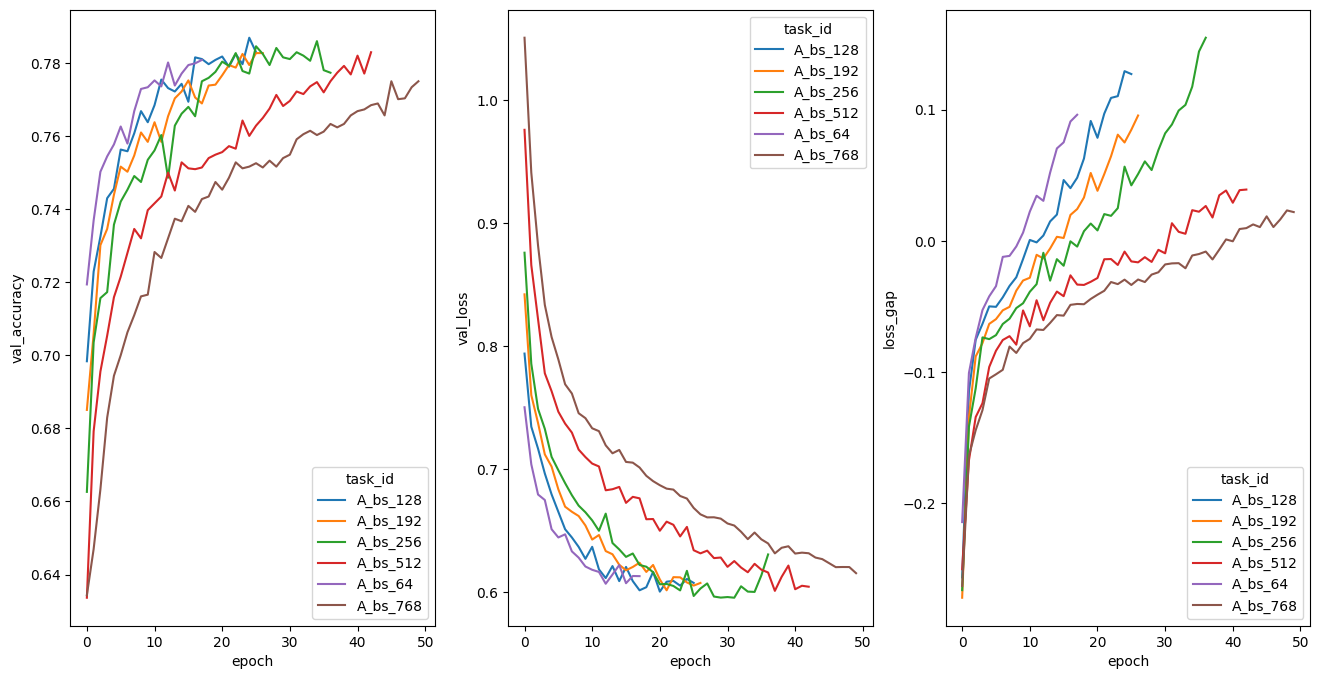

In [6]:
plot_experiments_comp2(df_res, df_res.task_id.unique())

Epsilon: 0.0025
Start: 2024-03-29 20:43:57.425413
Params(image_size=255, batch_size=256, epochs=50, epsilon=0.0025, early_stopping=True, early_stopping_patience=5, adjust_learning_rate=False)
Found 12837 files belonging to 5 classes.
Found 4280 files belonging to 5 classes.
Found 4280 files belonging to 5 classes.
Using EarlyStopping
Epoch 1/50


I0000 00:00:1711745083.631698    4874 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 845ms/step - accuracy: 0.5380 - loss: 1.2871

W0000 00:00:1711745126.416907    4877 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1711745126.417332    4877 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1711745126.417750    4877 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1711745126.418795    4877 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1711745126.419224    4877 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1711745126.419641    4877 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1711745126.420219    4877 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1711745126.420646    4877 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


51/51 ━━━━━━━━━━━━━━━━━━━━ 115s 1s/step - accuracy: 0.5392 - loss: 1.2836 - val_accuracy: 0.6925 - val_loss: 0.8257
Epoch 2/50
51/51 ━━━━━━━━━━━━━━━━━━━━ 52s 956ms/step - accuracy: 0.6623 - loss: 0.8996 - val_accuracy: 0.7159 - val_loss: 0.7524
Epoch 3/50
51/51 ━━━━━━━━━━━━━━━━━━━━ 52s 952ms/step - accuracy: 0.6886 - loss: 0.8176 - val_accuracy: 0.7290 - val_loss: 0.7313
Epoch 4/50
51/51 ━━━━━━━━━━━━━━━━━━━━ 52s 955ms/step - accuracy: 0.7033 - loss: 0.7871 - val_accuracy: 0.7297 - val_loss: 0.7109
Epoch 5/50
51/51 ━━━━━━━━━━━━━━━━━━━━ 52s 952ms/step - accuracy: 0.7166 - loss: 0.7588 - val_accuracy: 0.7502 - val_loss: 0.6880
Epoch 6/50
51/51 ━━━━━━━━━━━━━━━━━━━━ 52s 954ms/step - accuracy: 0.7282 - loss: 0.7309 - val_accuracy: 0.7493 - val_loss: 0.6861
Epoch 7/50
51/51 ━━━━━━━━━━━━━━━━━━━━ 52s 954ms/step - accuracy: 0.7323 - loss: 0.7195 - val_accuracy: 0.7519 - val_loss: 0.6655
Epoch 8/50
51/51 ━━━━━━━━━━━━━━━━━━━━ 52s 959ms/step - accuracy: 0.7435 - loss: 0.6979 - val_accuracy: 0.7568 

W0000 00:00:1711746568.732706    4874 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1711746568.733142    4874 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1711746568.733608    4874 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1711746568.734623    4874 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1711746568.734987    4874 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1711746568.735416    4874 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1711746568.735808    4874 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1711746568.736188    4874 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


51/51 ━━━━━━━━━━━━━━━━━━━━ 82s 1s/step - accuracy: 0.5214 - loss: 1.3331 - val_accuracy: 0.6689 - val_loss: 0.8898
Epoch 2/50
51/51 ━━━━━━━━━━━━━━━━━━━━ 52s 957ms/step - accuracy: 0.6485 - loss: 0.9613 - val_accuracy: 0.6995 - val_loss: 0.7909
Epoch 3/50
51/51 ━━━━━━━━━━━━━━━━━━━━ 52s 955ms/step - accuracy: 0.6807 - loss: 0.8548 - val_accuracy: 0.7159 - val_loss: 0.7553
Epoch 4/50
51/51 ━━━━━━━━━━━━━━━━━━━━ 52s 954ms/step - accuracy: 0.6905 - loss: 0.8234 - val_accuracy: 0.7199 - val_loss: 0.7346
Epoch 5/50
51/51 ━━━━━━━━━━━━━━━━━━━━ 52s 956ms/step - accuracy: 0.7033 - loss: 0.7987 - val_accuracy: 0.7322 - val_loss: 0.7148
Epoch 6/50
51/51 ━━━━━━━━━━━━━━━━━━━━ 52s 957ms/step - accuracy: 0.7111 - loss: 0.7683 - val_accuracy: 0.7444 - val_loss: 0.7042
Epoch 7/50
51/51 ━━━━━━━━━━━━━━━━━━━━ 51s 951ms/step - accuracy: 0.7136 - loss: 0.7614 - val_accuracy: 0.7428 - val_loss: 0.6933
Epoch 8/50
51/51 ━━━━━━━━━━━━━━━━━━━━ 82s 954ms/step - accuracy: 0.7242 - loss: 0.7357 - val_accuracy: 0.7493 -

W0000 00:00:1711748566.601895    4875 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1711748566.602275    4875 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1711748566.602715    4875 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1711748566.603722    4875 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1711748566.604122    4875 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1711748566.604509    4875 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1711748566.604876    4875 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1711748566.605242    4875 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


51/51 ━━━━━━━━━━━━━━━━━━━━ 80s 1s/step - accuracy: 0.5200 - loss: 1.3344 - val_accuracy: 0.6568 - val_loss: 0.9028
Epoch 2/50
51/51 ━━━━━━━━━━━━━━━━━━━━ 51s 948ms/step - accuracy: 0.6419 - loss: 0.9827 - val_accuracy: 0.6956 - val_loss: 0.8085
Epoch 3/50
51/51 ━━━━━━━━━━━━━━━━━━━━ 52s 955ms/step - accuracy: 0.6677 - loss: 0.8908 - val_accuracy: 0.7096 - val_loss: 0.7662
Epoch 4/50
51/51 ━━━━━━━━━━━━━━━━━━━━ 52s 954ms/step - accuracy: 0.6786 - loss: 0.8482 - val_accuracy: 0.7150 - val_loss: 0.7478
Epoch 5/50
51/51 ━━━━━━━━━━━━━━━━━━━━ 52s 953ms/step - accuracy: 0.6932 - loss: 0.8124 - val_accuracy: 0.7276 - val_loss: 0.7307
Epoch 6/50
51/51 ━━━━━━━━━━━━━━━━━━━━ 51s 953ms/step - accuracy: 0.6996 - loss: 0.7987 - val_accuracy: 0.7369 - val_loss: 0.7167
Epoch 7/50
51/51 ━━━━━━━━━━━━━━━━━━━━ 51s 947ms/step - accuracy: 0.7166 - loss: 0.7740 - val_accuracy: 0.7369 - val_loss: 0.7086
Epoch 8/50
51/51 ━━━━━━━━━━━━━━━━━━━━ 52s 958ms/step - accuracy: 0.7154 - loss: 0.7571 - val_accuracy: 0.7414 -

W0000 00:00:1711751144.372594    4876 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1711751144.372927    4876 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1711751144.373433    4876 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1711751144.374521    4876 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1711751144.374970    4876 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1711751144.375390    4876 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1711751144.375804    4876 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1711751144.376224    4876 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


51/51 ━━━━━━━━━━━━━━━━━━━━ 81s 1s/step - accuracy: 0.4958 - loss: 1.3727 - val_accuracy: 0.6418 - val_loss: 0.9329
Epoch 2/50
51/51 ━━━━━━━━━━━━━━━━━━━━ 52s 961ms/step - accuracy: 0.6351 - loss: 1.0062 - val_accuracy: 0.6841 - val_loss: 0.8326
Epoch 3/50
51/51 ━━━━━━━━━━━━━━━━━━━━ 52s 955ms/step - accuracy: 0.6620 - loss: 0.9094 - val_accuracy: 0.7012 - val_loss: 0.7856
Epoch 4/50
51/51 ━━━━━━━━━━━━━━━━━━━━ 51s 949ms/step - accuracy: 0.6724 - loss: 0.8649 - val_accuracy: 0.7100 - val_loss: 0.7606
Epoch 5/50
51/51 ━━━━━━━━━━━━━━━━━━━━ 52s 955ms/step - accuracy: 0.6872 - loss: 0.8250 - val_accuracy: 0.7201 - val_loss: 0.7435
Epoch 6/50
51/51 ━━━━━━━━━━━━━━━━━━━━ 52s 955ms/step - accuracy: 0.6937 - loss: 0.8090 - val_accuracy: 0.7297 - val_loss: 0.7311
Epoch 7/50
51/51 ━━━━━━━━━━━━━━━━━━━━ 82s 953ms/step - accuracy: 0.7068 - loss: 0.7831 - val_accuracy: 0.7313 - val_loss: 0.7210
Epoch 8/50
51/51 ━━━━━━━━━━━━━━━━━━━━ 52s 953ms/step - accuracy: 0.7090 - loss: 0.7759 - val_accuracy: 0.7322 -

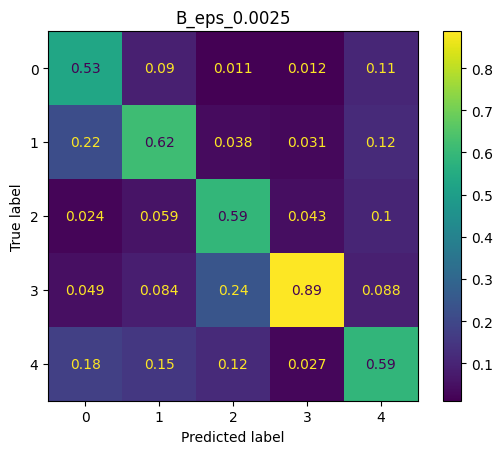

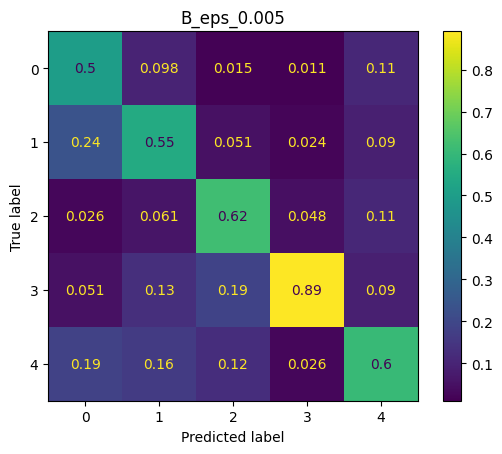

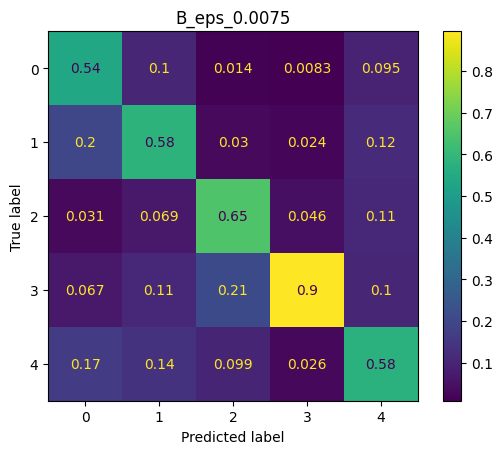

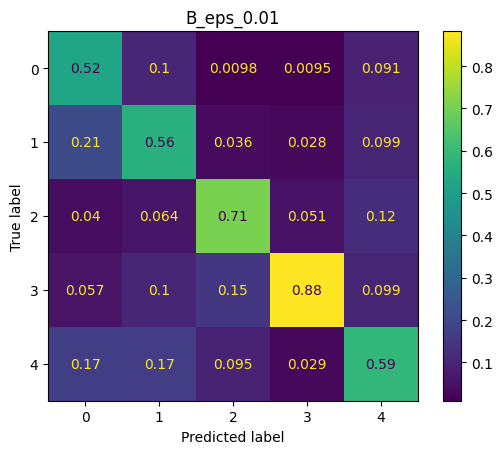

In [11]:
for eps in [0.0025, 0.0050, 0.0075, 0.01]:
    print(f"Epsilon: {eps}")
    print(f"Start: {datetime.datetime.now()}")
    params = Params(255, 256, 50, eps, True, 5, False)
    print(params)
    ds_train, ds_valid, ds_test, class_weights = data_preprocessing(Path(cwd), params)
    model = create_model(tf.keras.applications.ConvNeXtTiny, "base", params)
    df_train, df_test = run_task(f"B_eps_{eps}", model, ds_train, ds_valid, ds_test, params)
    collector.add_task_results(df_train, df_test)
    print(model.model.evaluate(ds_test))
    print(f"End: {datetime.datetime.now()}")

In [13]:
collector.get_test_scores()

,task_id,test_loss,test_accuracy
0,B_eps_0.0025,0.593052,0.782944
0,B_eps_0.005,0.590592,0.782009
0,B_eps_0.0075,0.584704,0.787150
0,B_eps_0.01,0.588137,0.786682


/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to 

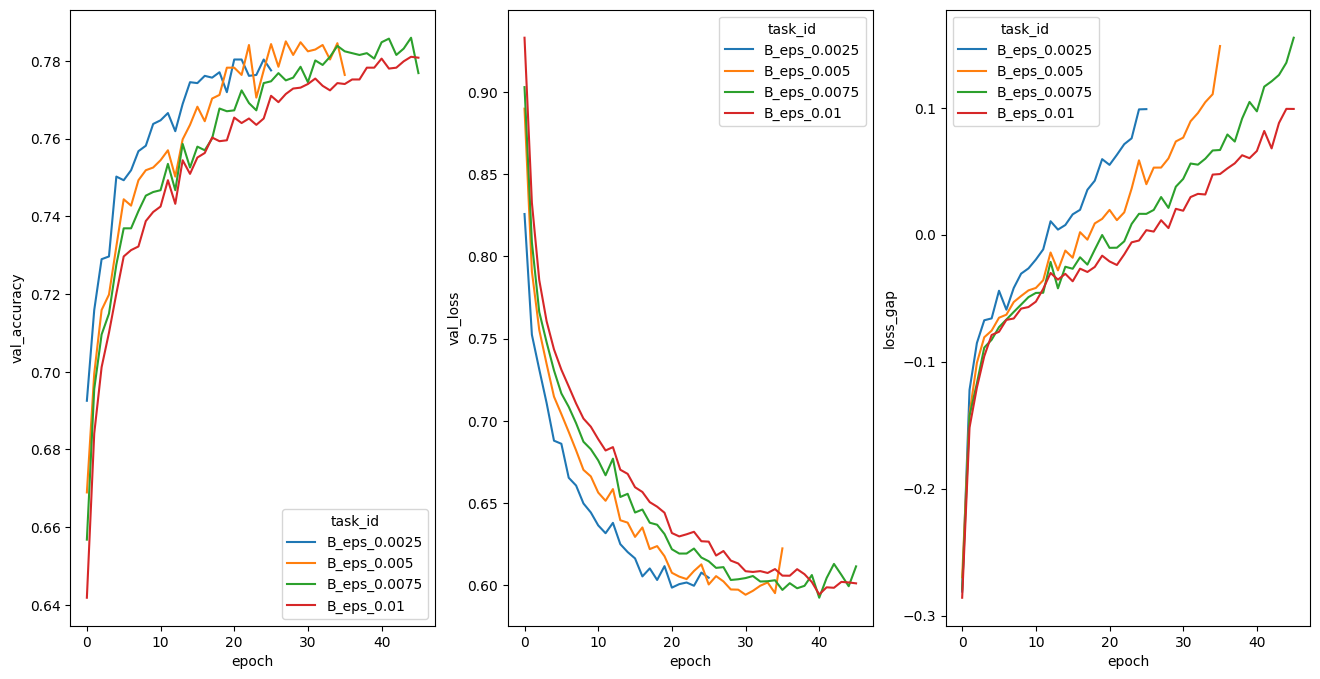

In [12]:
plot_experiments_comp2(collector.get_train_details(), collector.get_train_details().task_id.unique())

In [ ]:
print(datetime.datetime.now())
model_z = create_convnext_base(DEFAULT_PARAMS)
df_train, df_test = run_task("Z_base", model_z, ds_train, ds_valid, ds_test, DEFAULT_PARAMS)
collector.add_task_results(df_train, df_test)
print(datetime.datetime.now())

In [ ]:
print(datetime.datetime.now())
ds_train_aug = augment_dataset(ds_train, 3)
model_y = create_convnext_base(DEFAULT_PARAMS)
df_train, df_test = run_task("Y_base", model_y, ds_train_aug, ds_valid, ds_test, DEFAULT_PARAMS)
collector.add_task_results(df_train, df_test)
print(datetime.datetime.now())

In [ ]:
print(datetime.datetime.now())
ds_train_aug = augment_dataset(ds_train, 2)
model_b = create_convnext_base(DEFAULT_PARAMS)
df_train, df_test = run_task("B_base_aug", model_b, ds_train_aug, ds_valid, ds_test, DEFAULT_PARAMS)
collector.add_task_results(df_train, df_test)
print(datetime.datetime.now())

In [ ]:
model_b.model.save("/kaggle/working/artefacts/model_b.keras")

In [ ]:
del model_b
del model

In [ ]:
print(datetime.datetime.now())
ds_train_aug = augment_dataset(ds_train, 2)
model_c = create_convnext_base(DEFAULT_PARAMS)
df_train, df_test = run_task("C_base_aug_wgts", model_c, ds_train_aug, ds_valid, ds_test, DEFAULT_PARAMS, class_weights)
collector.add_task_results(df_train, df_test)  
print(datetime.datetime.now())

In [ ]:
model_c.model.save("/kaggle/working/artefacts/model_c.keras")

In [ ]:
model_c.model.evaluate(ds_test)

In [ ]:
pd.read_csv("/kaggle/working/artefacts/test_scores.csv")

In [ ]:
collector.get_test_scores()

In [ ]:
del model_c

In [ ]:
print(datetime.datetime.now())
fine_tune_params = Params(50, 196, 1, 1e-5, True, 5, False)
print(fine_tune_params)
model_c.base_model.trainable = True
df_train, df_test = run_task("D_base_aug_wgts_ft", model_c, ds_train, ds_valid, ds_test, DEFAULT_PARAMS, class_weights)
collector.add_task_results(df_train, df_test)
print(datetime.datetime.now())

In [ ]:
print(datetime.datetime.now())
ds_train_aug = augment_dataset(ds_train, 2)
model_d = create_model(tf.keras.applications.ConvNeXtTiny, "baseline", DEFAULT_PARAMS)
df_train, df_test = run_task("B_base_aug", model_d, ds_train_aug, ds_valid, ds_test, DEFAULT_PARAMS)
collector.add_task_results(df_train, df_test)
print(datetime.datetime.now())

In [ ]:
df_train

In [ ]:
df_test

In [ ]:
ARTEFACTS_PATH = Path("artefacts")
ARTEFACTS_PATH.mkdir(parents=True, exist_ok=True)

In [ ]:
ARTEFACTS_PATH

In [ ]:
collector = ResultCollector(ARTEFACTS_PATH)
collector.add_task_results(df_train, df_test)
collector.add_task_results(df_train2, df_test2)

In [ ]:
collector.add_train_details(df_train)
collector.add_test_scores(df_test)

In [ ]:
collector.get_train_details()

In [ ]:
collector.get_test_scores()

In [ ]:
pd.read_csv(ARTEFACTS_PATH / "train_details.csv")

In [ ]:
pd.read_csv(ARTEFACTS_PATH / "test_scores.csv")

`older_code`

In [ ]:
#!rm -rf /kaggle/working/data
#!rm /kaggle/working/data.zip

In [ ]:
# import keras

# import pandas as pd
# import random
# import shutil
# import tensorflow as tf
# import os
# import zipfile

# from collections import Counter

# from pathlib import Path
# from sklearn.model_selection import train_test_split

# from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
# from tensorflow.keras import layers, callbacks
# from tensorflow.keras.models import Model


# from tensorflow.keras.layers import Dense, Dropout, Flatten, GlobalAveragePooling2D

# from tensorflow.data import Dataset

# from typing import NamedTuple, Tuple

# import matplotlib.pyplot as plt
# import seaborn as sns

In [ ]:
# def data_cleanup() -> None:
#     # clean-up
#     try:
#         os.rmdir((data_path / "train_images"))
#         os.remove(file)
#     except Exception:
#          pass

In [ ]:
df = create_test_record("test_task", [1.0, 2.0])

In [ ]:
pd.concat([df, create_test_record("test_task", [1.0, 2.0])])

In [ ]:




# Large VGG-like model
def fatVGG(cifarInput, num_classes, name="vgg"):
    name = [name+str(i) for i in range(17)]
    
    # convolution and max pooling layers
    vgg = Conv2D(32, (3, 3), padding='same', activation='relu', name=name[0])(cifarInput)
    vgg = Conv2D(32, (3, 3), padding='same', activation='relu', name=name[1])(vgg)
    vgg = MaxPooling2D(pool_size=(2,2), name=name[2])(vgg)
    vgg = Dropout(0.25, name=name[3])(vgg)
    vgg = Conv2D(64, (3, 3), padding='same', activation='relu', name=name[4])(vgg)
    vgg = Conv2D(64, (3, 3), padding='same', activation='relu', name=name[5])(vgg)
    vgg = MaxPooling2D(pool_size=(2,2), name=name[6])(vgg)
    vgg = Dropout(0.25, name=name[7])(vgg)
    vgg = Conv2D(128, (3, 3), padding='same', activation='relu', name=name[8])(vgg)
    vgg = Conv2D(128, (3, 3), padding='same', activation='relu', name=name[9])(vgg)
    vgg = Conv2D(128, (3, 3), padding='same', activation='relu', name=name[10])(vgg)
    vgg = MaxPooling2D(pool_size=(2,2), name=name[11])(vgg)
    vgg = Dropout(0.25, name=name[12])(vgg)

    # classification layers
    vgg = Flatten(name=name[13])(vgg)
    vgg = Dense(512, activation='relu', name=name[14])(vgg)
    vgg = Dropout(0.5, name=name[15])(vgg)
    vgg = Dense(num_classes, activation='softmax', name=name[16])(vgg)
    return vgg


def model_convnext_tiny(params: Params) -> Model:
    
    base_model = tf.keras.applications.ConvNeXtTiny(weights='imagenet', include_top=False)
    base_model.trainable = False
    
    img_size = params.image_size
    
    return keras.Sequential([
        
        tf.keras.Input(shape=(img_size, img_size, 3)),
        
        base_model,
        layers.GlobalAveragePooling2D(),

        # Classifier Head
        layers.Flatten(),
        layers.Dense(1024, activation='relu'),
        layers.Dropout(0.5),
        layers.Dense(1024, activation='relu'),
        layers.Dropout(0.5),
        layers.Dense(units=5, activation="softmax"),
    ])


def model_convnext_base(params: Params) -> Model:
    
    base_model = tf.keras.applications.ConvNeXtBase(weights='imagenet', include_top=False)
    base_model.trainable = False
    
    img_size = params.image_size
    
    return keras.Sequential([
        
        tf.keras.Input(shape=(img_size, img_size, 3)),
        
        base_model,
        layers.GlobalAveragePooling2D(),

        # Classifier Head
        layers.Flatten(),
        layers.Dense(1024, activation='relu'),
        layers.Dropout(0.5),
        layers.Dense(1024, activation='relu'),
        layers.Dropout(0.5),
        layers.Dense(units=5, activation="softmax"),
    ])


def model_convnext_tiny_1fc(params: Params) -> Model:
    
    base_model = tf.keras.applications.ConvNeXtTiny(weights='imagenet', include_top=False)
    base_model.trainable = False
    
    img_size = params.image_size
    
    return keras.Sequential([
        
        tf.keras.Input(shape=(img_size, img_size, 3)),
        
        base_model,
        layers.GlobalAveragePooling2D(),

        # Classifier Head
        layers.Flatten(),
        layers.Dense(1024, activation='relu'),
        layers.Dropout(0.5),
        layers.Dense(units=5, activation="softmax"),
    ])


def model_effnet(params: Params) -> Model:
    
    base_model = tf.keras.applications.EfficientNetB0(weights='imagenet', include_top=False)
    base_model.trainable = False
    
    img_size = params.image_size
    
    return keras.Sequential([
        
        tf.keras.Input(shape=(img_size, img_size, 3)),
        
        base_model,
        layers.GlobalAveragePooling2D(),

        # Classifier Head
        layers.Flatten(),
        layers.Dense(1024, activation='relu'),
        layers.Dropout(0.5),
        layers.Dense(1024, activation='relu'),
        layers.Dropout(0.5),
        layers.Dense(units=5, activation="softmax"),
    ])


def model_effnetv2(params: Params) -> Model:
    
    base_model = tf.keras.applications.EfficientNetV2B0(weights='imagenet', include_top=False)
    base_model.trainable = False
    
    img_size = params.image_size
    
    return keras.Sequential([
        
        tf.keras.Input(shape=(img_size, img_size, 3)),
        
        base_model,
        layers.GlobalAveragePooling2D(),

        # Classifier Head
        layers.Flatten(),
        layers.Dense(1024, activation='relu'),
        layers.Dropout(0.5),
        layers.Dense(1024, activation='relu'),
        layers.Dropout(0.5),
        layers.Dense(units=5, activation="softmax"),
    ])


def effnet2(params: Params) -> Model:
    base_model = tf.keras.applications.EfficientNetV2B0(weights='imagenet', include_top=False)
    base_model.trainable = False
    inputs = keras.Input(shape=(params.image_size, params.image_size, 3))
    x = base_model(inputs, training=False)
    x = keras.layers.GlobalAveragePooling2D()(x)
    x = keras.layers.Flatten()(x)
    x = keras.layers.Dense(1024, activation="relu")(x)
    x = keras.layers.Dropout(0.5)(x)
    x = keras.layers.Dense(1024, activation="relu")(x)
    x = keras.layers.Dropout(0.5)(x)
    outputs = keras.layers.Dense(5, activation="softmax")(x)
    model = keras.Model(inputs, outputs)
    return model
    
    
#keras.utils.plot_model(mod.model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)


def train(task_id: str, model: Model,
             ds_train_: Dataset, ds_valid_: Dataset,
             params: Params, weights = None) -> pd.DataFrame:
    
    model.compile(
        optimizer=tf.keras.optimizers.Adam(epsilon=0.005),
        loss="categorical_crossentropy",
        metrics=['accuracy']
    )

    early_stopping = callbacks.EarlyStopping(
        min_delta=0.0001,
        patience=params.early_stopping_patience,
        restore_best_weights=True,
        verbose = 1
    )
    
    reduce_lr = callbacks.ReduceLROnPlateau(
        monitor = 'val_loss', factor = 0.3, 
        patience = 3, min_delta = 0.001, 
        mode = 'min', verbose = 1)
    
    cbs = []
    if params.early_stopping:
        print("Using EarlyStopping")
        cbs += [early_stopping]
    if params.adjust_learning_rate:
        print("Using ReduceLROnPlateau")
        cbs += [reduce_lr]

    history = model.fit(
        ds_train_,
        validation_data=ds_valid_,
        epochs=params.epochs,
        verbose=1,
        callbacks=cbs,
        class_weight=weights
    )
   
    df_hist = pd.DataFrame(history.history)
    df_hist = df_hist.reset_index()
    df_hist["task_id"] = task_id
    df_hist["epoch"] = df_hist.index
   
    return df_hist


def run_experiment(exp_id: str, sub_exp_id: int, model_fn: str,
                      ds_train_: Dataset, ds_valid_: Dataset, params: Params, weights = None) -> Tuple[Model, pd.DataFrame]:
    
    model = model_fn(params)
    
    model.compile(
        optimizer=tf.keras.optimizers.Adam(epsilon=0.005),
        loss="categorical_crossentropy",
        metrics=['accuracy']
    )

    early_stopping = callbacks.EarlyStopping(
        min_delta=0.0001,
        patience=params.early_stopping_patience,
        restore_best_weights=True,
        verbose = 1
    )
    
    reduce_lr = callbacks.ReduceLROnPlateau(
        monitor = 'val_loss', factor = 0.3, 
        patience = 3, min_delta = 0.001, 
        mode = 'min', verbose = 1)
    
    cbs = []
    if params.early_stopping:
        print("Using EarlyStopping")
        cbs += [early_stopping]
    if params.adjust_learning_rate:
        print("Using ReduceLROnPlateau")
        cbs += [reduce_lr]

    history = model.fit(
        ds_train_,
        validation_data=ds_valid_,
        epochs=params.epochs,
        verbose=1,
        callbacks=cbs,
        class_weight=weights
    )
    
    
    
    df_hist = pd.DataFrame(history.history)
    df_hist = df_hist.reset_index()
    df_hist["exp_id"] = exp_id
    df_hist["sub_exp_id"] = sub_exp_id
    df_hist["epoch"] = df_hist.index
   
    return model, df_hist

In [ ]:
def add_results(df_all_results, df_new_results):
    if df_all_results.empty:
        return df_new_results
    else:
        return pd.concat([df_all_results, df_new_results])
    

def add_test_results(df_all_results: pd.DataFrame, exp_id: str, res: list[float]):
    df_res = pd.DataFrame({"exp_id": [exp_id], "test_loss" : [res[0]], "test_accuracy": [res[1]]})
    if df_all_results.empty:
        return df_res
    else:
        return pd.concat([df_all_results, df_res])


def recover_results() -> pd.DataFrame:
    file = "results.csv"
    if Path(file).exists():
        return pd.read_csv(file)
    return pd.DataFrame()


def recover_test_results() -> pd.DataFrame:
    file = "test_results.csv"
    if Path(file).exists():
        return pd.read_csv(file)
    return pd.DataFrame()

In [11]:
def plot_experiment_results(df_history: pd.DataFrame, exp_id: str, epoch_limit = 50) -> None:
    df = df_history[(df_history.exp_id == exp_id) & (df_history.epoch <= epoch_limit)].copy()
    df["loss_gap"] = df.val_loss - df.loss
    df_loss = df[["epoch", "loss", "val_loss"]].groupby(["epoch"]).mean()
    df_loss_gap = df[["epoch", "loss_gap"]].groupby(["epoch"]).mean()
    df_acc = df[["epoch", "accuracy", "val_accuracy"]].groupby(["epoch"]).mean()
    df_loss.plot()
    df_loss_gap.plot()
    df_acc.plot();
    
def plot_experiments_comp(df_history: pd.DataFrame, exp_id: list, y_dim: str, epoch_limit = 50) -> None:
    df = df_history[(df_history.exp_id.isin(exp_id)) & (df_history.epoch <= epoch_limit)].copy()
    df["loss_gap"] = df.val_loss - df.loss
    df_grp = df[["epoch","exp_id", y_dim]].groupby(["epoch", "exp_id"]).mean()
    sns.lineplot(data=df_grp, x="epoch", y=y_dim, hue="exp_id")

In [12]:
def plot_experiments_comp2(df_history: pd.DataFrame, exp_id: list, epoch_limit = 50) -> None:
    df = df_history[(df_history.exp_id.isin(exp_id)) & (df_history.epoch <= epoch_limit)].copy()
    df["loss_gap"] = df.val_loss - df.loss
    df_grp = df[["epoch","exp_id", "val_accuracy", "val_loss", "loss_gap"]].groupby(["epoch", "exp_id"]).mean()
    fig, (ax1, ax2, ax3) = plt.subplots(ncols=3, figsize=(16, 8))
    sns.lineplot(data=df_grp, x="epoch", y="val_accuracy", hue="exp_id",  ax=ax1)
    sns.lineplot(data=df_grp, x="epoch", y="val_loss", hue="exp_id",  ax=ax2)
    sns.lineplot(data=df_grp, x="epoch", y="loss_gap", hue="exp_id",  ax=ax3)

`main.py`

In [ ]:
cwd = os.getcwd()
ds_train, ds_valid, ds_test, class_weights = data_preprocessing(Path(cwd), DEFAULT_PARAMS)
print(f"Class Weights: {class_weights}")

#df_results = recover_results()
#df_test_results = recover_test_results()

In [ ]:
# augmented datasets
#ds_train_aug = augment_dataset(ds_train, 1)
#ds_train_aug_lg = augment_dataset(ds_train, 2)
#ds_train_aug_xlg = augment_dataset(ds_train, 4)

In [ ]:
df_results.head()

In [ ]:
df_test_results.head()

`experiments/tasks`

In [ ]:
DEFAULT_PARAMS = Params(255, 196, 2, True, 5, False)

In [ ]:
ARTIFACTS_PATH = Path("artefacts").mkdir(parents=True, exist_ok=True)


In [ ]:
def run_task(task_id: str, model_wrapper: ModelWrapper,
             ds_train_: Dataset, ds_valid_: Dataset, ds_test_: Dataset,
             params: Params, weights = None) -> Tuple[pd.DataFrame, pd.DataFrame]:
    
    model = model_wrapper.model
    # train
    df_train = train(task_id, model, ds_train, ds_valid, DEFAULT_PARAMS)
    # test
    test_result = model.evaluate(ds_test)
    df_test = create_test_record(task_id, test_result)
    # save CM too
    save_confusion_matrix(ds_test, model, task_id)
    return df_train, df_test

In [ ]:
def create_test_record(task_id: str, result: list[float]):
    return pd.DataFrame({"task_id": [task_id], "test_loss" : [result[0]], "test_accuracy": [result[1]]})

In [ ]:
baseline_model = create_model(tf.keras.applications.ConvNeXtBase, "baseline_model", DEFAULT_PARAMS)
df_train, df_test = run_task("convnextbase", baseline_model, ds_train, ds_valid, ds_test, DEFAULT_PARAMS)

In [ ]:
df_train

In [ ]:
df_test

In [ ]:
    df_train = run_task("model_convnext_tiny", baseline_model.model,
                   ds_train, ds_valid, DEFAULT_PARAMS)

In [ ]:
df_results = add_results(df_results, df_hist)

In [ ]:
df_results

In [ ]:
baseline_model.model.evaluate(ds_valid)

In [ ]:
tr = baseline_model.model.evaluate(ds_test)
df_test_results = add_test_results(df_test_results, "convnext_tiny", tr)
tr

In [ ]:
baseline_model.base_model.trainable = True
df_hist2 = run_task("convnext_tiny_ft", baseline_model.model,
                   ds_train, ds_valid, DEFAULT_PARAMS)

In [ ]:
tr2 = baseline_model.model.evaluate(ds_test)
df_test_results = add_test_results(df_test_results, "convnext_tiny_ft", tr2)
tr2

In [ ]:
df_test_results

In [ ]:
plot_confusion_matrix(ds_test, baseline_model.model)

In [ ]:
df_hist = run_task("model_convnext_tiny", baseline_model.model,
                   ds_train, ds_valid, DEFAULT_PARAMS)

In [ ]:
(m, df_hist) = run_experiment("model_convnext_tiny", 1, model_convnext_tiny, ds_train_aug_lg, ds_valid, DEFAULT_PARAMS)
df_results = add_results(df_results, df_hist)
    
df_results.to_csv("results.csv")

m.evaluate(ds_test)

In [ ]:
(m1, df_hist) = run_experiment("model_convnext_base_orig_img", 1, model_convnext_base, augment_dataset(ds_train, 4), ds_valid, DEFAULT_PARAMS)
df_results = add_results(df_results, df_hist)
    
df_results.to_csv("results.csv")

m1.evaluate(ds_test)

In [ ]:
(m1a, df_hist) = run_experiment("model_convnext_base_orig_img_all", 1, model_convnext_base, augment_dataset(ds_train, 1), ds_valid, DEFAULT_PARAMS, class_weights)
df_results = add_results(df_results, df_hist)
    
df_results.to_csv("results.csv")

m1.evaluate(ds_test)

In [ ]:
(m1b, df_hist) = run_experiment("model_convnext_base_orig_img_all_no_wgt", 1, model_convnext_base, augment_dataset(ds_train, 1), ds_valid, DEFAULT_PARAMS)
df_results = add_results(df_results, df_hist)
    
df_results.to_csv("results.csv")

m1b.evaluate(ds_test)

In [ ]:
(m2, df_hist) = run_experiment("model_convnext_tiny_aug_sm", 1, model_convnext_tiny, ds_train_aug, ds_valid, DEFAULT_PARAMS)
df_results = add_results(df_results, df_hist)

df_results.to_csv("results.csv")

m2.evaluate(ds_test)

In [ ]:
plot_experiments_comp(df_results,["model_convnext_tiny", "model_convnext_tiny_aug", "model_convnext_tiny_aug4_sm"], "val_accuracy")

In [ ]:
plot_experiments_comp(df_results,["model_convnext_tiny", "model_convnext_tiny_aug"], "val_loss")

In [ ]:
(m3, df_hist) = run_experiment("model_convnext_tiny_aug4_sm", 1, model_convnext_tiny, ds_train_aug_lg, ds_valid, DEFAULT_PARAMS)
df_results = add_results(df_results, df_hist)

df_results.to_csv("results.csv")

m3.evaluate(ds_test)

In [ ]:
df_results.head()

In [ ]:
plot_experiments_comp(df_results,["model_convnext_tiny_aug", "model_convnext_tiny_sm", "model_convnext_tiny_aug_sm", "model_convnext_tiny_aug4_sm"], "val_accuracy")

In [ ]:
(m4, df_hist) = run_experiment("model_convnext_tiny_1fc", 1, model_convnext_tiny_1fc, ds_train_aug_lg, ds_valid, DEFAULT_PARAMS)
df_results = add_results(df_results, df_hist)

df_results.to_csv("results.csv")

m4.evaluate(ds_test)

In [ ]:
plot_experiments_comp2(df_results,["model_convnext_tiny_1fc", "model_convnext_tiny_aug", "model_convnext_tiny_sm", "model_convnext_tiny_aug_sm", "model_convnext_tiny_aug4_sm"], "val_loss")

In [ ]:
(m4, df_hist) = run_experiment("model_effnetv2", 1, model_effnetv2, ds_train_aug_lg, ds_valid, DEFAULT_PARAMS)
df_results = add_results(df_results, df_hist)
    
df_results.to_csv("results.csv")

m4.evaluate(ds_test)

In [ ]:
(m5, df_hist) = run_experiment("model_effnet", 1, model_effnet, ds_train_aug_lg, ds_valid, DEFAULT_PARAMS)
df_results = add_results(df_results, df_hist)

df_results.to_csv("results.csv")

r5 = m5.evaluate(ds_test)
df_test_results = add_test_results(df_test_results, "model_effnet", r5)
print(r5)

In [ ]:
(m6, df_hist) = run_experiment("model_effnet_wgts", 1, model_effnet, ds_train_aug_lg, ds_valid, DEFAULT_PARAMS, class_weights)
df_results = add_results(df_results, df_hist)
    
df_results.to_csv("results.csv")

r6 = m6.evaluate(ds_test)
df_test_results = add_test_results(df_test_results, "model_effnet", r6)
print(r6)

In [ ]:
print(r6)

In [ ]:
(m7, df_hist) = run_experiment("effnet2", 1, effnet2, ds_train_aug_lg, ds_valid, DEFAULT_PARAMS, class_weights)
df_results = add_results(df_results, df_hist)
    
df_results.to_csv("results.csv")

r7 = m7.evaluate(ds_test)
df_test_results = add_test_results(df_test_results, "effnet2", r6)
print(r7)

In [ ]:
plot_experiments_comp2(df_results,["model_effnet", "model_effnet_wgts"])

In [ ]:
plot_experiments_comp2(df_results,["model_convnext_tiny_1fc", "model_convnext_tiny_aug", "model_effnetv2", "model_effnet"])

In [ ]:
params = DEFAULT_PARAMS
weights = class_weights
    
base_model = tf.keras.applications.EfficientNetV2B0(weights='imagenet', include_top=False)
base_model.trainable = False
inputs = keras.Input(shape=(params.image_size, params.image_size, 3))
x = base_model(inputs, training=False)
x = keras.layers.GlobalAveragePooling2D()(x)
x = keras.layers.Flatten()(x)
#x = keras.layers.Dense(1024, activation="relu")(x)
#x = keras.layers.Dropout(0.5)(x)
x = keras.layers.Dense(1024, activation="relu")(x)
x = keras.layers.Dropout(0.5)(x)
outputs = keras.layers.Dense(5, activation="softmax")(x)
model = keras.Model(inputs, outputs)

model.compile(
    optimizer=tf.keras.optimizers.Adam(epsilon=0.005),
    loss="categorical_crossentropy",
    metrics=['accuracy']
)

early_stopping = callbacks.EarlyStopping(
    min_delta=0.0001,
    patience=params.early_stopping_patience,
    restore_best_weights=True,
    verbose = 1
)

reduce_lr = callbacks.ReduceLROnPlateau(
    monitor = 'val_loss', factor = 0.3, 
    patience = 3, min_delta = 0.001, 
    mode = 'min', verbose = 1)

cbs = []
if params.early_stopping:
    print("Using EarlyStopping")
    cbs += [early_stopping]
if params.adjust_learning_rate:
    print("Using ReduceLROnPlateau")
    cbs += [reduce_lr]

history = model.fit(
    ds_train_aug_lg,
    validation_data=ds_valid,
    epochs=params.epochs,
    verbose=1,
    callbacks=cbs,
    class_weight = None
)


In [ ]:
model.evaluate(ds_test)

In [ ]:
base_model.trainable = True

model.compile(
    optimizer=tf.keras.optimizers.Adam(epsilon=1e-5),
    loss="categorical_crossentropy",
    metrics=['accuracy']
)

history2 = model.fit(
    ds_train_aug_lg,
    validation_data=ds_valid,
    epochs=params.epochs,
    verbose=1,
    callbacks=cbs,
    class_weight=None
)

In [ ]:
model.evaluate(ds_test)
# [0.4968397915363312, 0.8268691301345825]

In [ ]:
model_eff = model

In [ ]:
params = DEFAULT_PARAMS
weights = class_weights
    
base_model = tf.keras.applications.ConvNeXtTiny(weights='imagenet', include_top=False)
base_model.trainable = False
inputs = keras.Input(shape=(params.image_size, params.image_size, 3))
x = base_model(inputs, training=False)
x = keras.layers.GlobalAveragePooling2D()(x)
x = keras.layers.Flatten()(x)
x = keras.layers.Dense(1024, activation="relu")(x)
x = keras.layers.Dropout(0.5)(x)
x = keras.layers.Dense(1024, activation="relu")(x)
x = keras.layers.Dropout(0.5)(x)
outputs = keras.layers.Dense(5, activation="softmax")(x)
model = keras.Model(inputs, outputs)

model.compile(
    optimizer=tf.keras.optimizers.Adam(epsilon=0.005),
    loss="categorical_crossentropy",
    metrics=['accuracy']
)

early_stopping = callbacks.EarlyStopping(
    min_delta=0.0001,
    patience=params.early_stopping_patience,
    restore_best_weights=True,
    verbose = 1
)

reduce_lr = callbacks.ReduceLROnPlateau(
    monitor = 'val_loss', factor = 0.3, 
    patience = 3, min_delta = 0.001, 
    mode = 'min', verbose = 1)

cbs = []
if params.early_stopping:
    print("Using EarlyStopping")
    cbs += [early_stopping]
if params.adjust_learning_rate:
    print("Using ReduceLROnPlateau")
    cbs += [reduce_lr]

history = model.fit(
    ds_train_aug_lg,
    validation_data=ds_valid,
    epochs=params.epochs,
    verbose=1,
    callbacks=cbs,
    class_weight = weights
)

In [ ]:
model.evaluate(ds_test)

In [ ]:
base_model.trainable = True

model.compile(
    optimizer=tf.keras.optimizers.Adam(epsilon=1e-5),
    loss="categorical_crossentropy",
    metrics=['accuracy']
)

history2 = model.fit(
    ds_train_aug_lg,
    validation_data=ds_valid,
    epochs=params.epochs,
    verbose=1,
    callbacks=cbs,
    class_weight = weights
)

In [ ]:
model.model.evaluate(ds_test)

In [ ]:
del ds_train

In [ ]:
preds = model.predict(ds_test)

In [ ]:
m1.evaluate(ds_test)

In [ ]:
m1.evaluate(ds_valid)

In [ ]:
probabilities = model.model.predict(xs)
predictions = np.argmax(probabilities, axis=1)
#Counter(predictions)

In [ ]:
xs = np.concatenate([x for x, y in ds_test], axis=0)

In [ ]:
probabilities = m1.predict(ds_test2)
predictions = np.argmax(probabilities, axis=1)
Counter(predictions)

In [ ]:
probabilities = m1a.predict(ds_test2)
predictions = np.argmax(probabilities, axis=1)
Counter(predictions)

In [ ]:
import matplotlib.pyplot as plt

In [ ]:
y = np.concatenate([y for x, y in ds_test], axis=0)
ys = [np.argmax(x) for x in y]

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
#Create confusion matrix and normalizes it over predicted (columns)
result = confusion_matrix(ys, predictions, labels=[0,1,2,3,4], normalize='pred')
print(result)

In [ ]:
disp = ConfusionMatrixDisplay(result, display_labels=[0,1,2,3,4])
disp.plot()
plt.show()

In [ ]:
ds_test2 = image_dataset_from_directory(
        Path("/kaggle/working/data/test/"),
        labels='inferred',
        label_mode='categorical',
        image_size=[255, 255],
        batch_size=196,
        shuffle=False
    )

In [ ]:
model.model.evaluate(ds_test2)

In [ ]:
probabilities = model.model.predict(ds_test2)
predictions = np.argmax(probabilities, axis=1)
#Counter(predictions)

y = np.concatenate([y for x, y in ds_test2], axis=0)
ys = [np.argmax(x) for x in y]

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
#Create confusion matrix and normalizes it over predicted (columns)
result = confusion_matrix(ys, predictions, labels=[0,1,2,3,4], normalize='pred')
disp = ConfusionMatrixDisplay(result, display_labels=[0,1,2,3,4])
disp.plot()
plt.show()

In [ ]:


def plot_confusion_matrix(ds: Dataset, model: Model) -> None:
    probabilities = model.predict(ds)
    predictions = np.argmax(probabilities, axis=1)

    one_hot_labels = np.concatenate([y for x, y in ds], axis=0)
    labels = [np.argmax(x) for x in one_hot_labels]
    
    result = confusion_matrix(labels, predictions, labels=[0,1,2,3,4], normalize='pred')
    disp = ConfusionMatrixDisplay(result, display_labels=[0,1,2,3,4])
    disp.plot()
    plt.show()

In [ ]:
m1b.evaluate(ds_valid)

In [ ]:
m1b.evaluate(ds_test)

In [ ]:
plot_confusion_matrix(ds_test2, m1b)